In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# filter only test players
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

1187

In [25]:
# player stats

In [26]:
df.head()

,playerId,target1,target2,target3,target4,date,home,pstatsDate,battingOrder__ptvf,groundOuts__ptvf,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaT,NaN,NaN,...,0,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaT,NaN,NaN,...,1,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaT,NaN,NaN,...,2,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaT,NaN,NaN,...,3,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaT,NaN,NaN,...,4,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661


### dummy models

In [27]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [28]:
yhat_cols = ['yhat1', 'yhat2', 'yhat3', 'yhat4']

In [29]:
def rename_to_yhat(df: pd.DataFrame):
    return df.rename(columns={f: f.replace('target', 'yhat') for f in target_cols})

In [30]:
class LastMean:
    def __init__(self, window: int = 7,
                 on=['playerId']):
        self.window = window
        self.on = on
        self.index_cols = on + ['date']

    def fit(self, X: pd.DataFrame, y=None):
        max_date = X['date'].max()
        first_date = max_date - pd.to_timedelta(self.window, unit='d')
        data = X.loc[X.date.between(first_date, max_date), :]
        self.mean = (data.groupby(self.on)[target_cols]
                     .mean().reset_index())
        return self

    def predict(self, X: pd.DataFrame):
        outputX = X.loc[:, self.index_cols]
        outputX = outputX.merge(self.mean, how='left', on=self.on)
        return outputX.drop(self.index_cols, axis=1).to_numpy()

In [31]:
from data.split import SplitData
from evaluate.metrics import compute_metrics

In [32]:
test_dates = ['2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01']

In [33]:
df.columns

Index(['playerId', 'target1', 'target2', 'target3', 'target4', 'date', 'home',
       'pstatsDate', 'battingOrder__ptvf', 'groundOuts__ptvf',
       'runsScored__ptvf', 'homeRuns__ptvf', 'strikeOuts__ptvf',
       'baseOnBalls__ptvf', 'intentionalWalks__ptvf', 'hits__ptvf',
       'hitByPitch__ptvf', 'stolenBases__ptvf', 'groundIntoTriplePlay__ptvf',
       'plateAppearances__ptvf', 'totalBases__ptvf', 'rbi__ptvf',
       'catchersInterference__ptvf', 'pickoffs__ptvf',
       'gamesPlayedPitching__ptvf', 'gamesStartedPitching__ptvf',
       'completeGamesPitching__ptvf', 'winsPitching__ptvf',
       'lossesPitching__ptvf', 'groundOutsPitching__ptvf',
       'runsPitching__ptvf', 'strikeOutsPitching__ptvf',
       'atBatsPitching__ptvf', 'caughtStealingPitching__ptvf',
       'inningsPitched__ptvf', 'saveOpportunities__ptvf', 'battersFaced__ptvf',
       'outsPitching__ptvf', 'balks__ptvf', 'pickoffsPitching__ptvf',
       'gamesFinishedPitching__ptvf', 'inheritedRunners__ptvf',
       

In [42]:
predictions = []
for test_date in test_dates:
    # split the data on 2021-03-01 with a valid ds of 61 days
    sp = SplitData(test_date, test_days=45)

    train_idx = sp.train_idx(df)
    valid_idx = sp.valid_idx(df)
    train_data = df.loc[train_idx, :].reset_index(drop=True)
    valid_data = df.loc[valid_idx, :].reset_index(drop=True)
    
    model = LastMean(on=['playerId'], window=30).fit(train_data)
    
    fold_prediction = model.predict(valid_data)
    
    fold_prediction = pd.DataFrame(fold_prediction, columns=yhat_cols)
    fold_prediction[pp_cols] = valid_data[pp_cols]
    predictions.append(fold_prediction)
predictions = pd.concat(predictions, ignore_index=True)

In [43]:
predictions.head()

,yhat1,yhat2,yhat3,yhat4,target1,target2,target3,target4,date,playerId
0,2.817864,22.103254,1.775517,49.792317,9.051319,37.249410,84.337685,61.795191,2021-04-01,405395
1,2.817864,22.103254,1.775517,49.792317,23.797576,16.486389,1.830379,43.453768,2021-04-02,405395
2,2.817864,22.103254,1.775517,49.792317,1.582325,11.661471,0.446259,16.009967,2021-04-03,405395
3,2.817864,22.103254,1.775517,49.792317,0.398015,17.862383,0.236858,11.990867,2021-04-04,405395
4,2.817864,22.103254,1.775517,49.792317,0.105217,29.070086,0.311580,18.445448,2021-04-05,405395


In [44]:
compute_metrics(predictions)

{'mae_mean': 2.0791200174930995,
 'mae_1': 1.7628725900788997,
 'mae_2': 3.297799226594636,
 'mae_3': 1.5039028739191298,
 'mae_4': 1.7519053793797323}

In [45]:
(predictions.groupby(predictions.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,2.683919,2.013451,4.712878,1.921143,2.088204
5,2.215226,1.836495,3.596448,1.600056,1.827907
6,1.872807,1.705837,2.791418,1.365033,1.628939
7,1.600149,1.500547,2.238130,1.165467,1.496451


In [65]:
raw_features = list(df.columns.drop(['playerId',
 'target1',
 'target2',
 'target3',
 'target4',
 'year',
 'date', 'playerId'] + inplace_ffill_features) )

In [78]:
# transformer for filling nan values with past valid values
# transformer for generating some hardcoded features
inplace_fill_forward_tmf = FunctionTransformer(forward_fill,
                                               kw_args={'features': inplace_ffill_features,
                                                        'on': ['playerId', 'year']})
inplace_feat_fill_forward_tmf = FunctionTransformer(forward_fill,
                                                    kw_args={'features': raw_features,
                                                        'on': ['playerId', 'year'],
                                                         'limit':7    })
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [79]:
# creating pipeline
ffill_and_gen_harcoded_feat = Pipeline([('inplace_fill_forward', inplace_fill_forward_tmf),
                                        ('inplace_feat_fill_forward', inplace_feat_fill_forward_tmf),
                                        ('hardcoded_feat', harcoded_feat_tmf)])

In [80]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [81]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year', 'primaryPositionName',
              'status', 'teamId',
              'opponentTeamId', 'home', 'seriesDescription', 'currentGameInSeries']

In [82]:
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [83]:
from sklearn.preprocessing import KBinsDiscretizer

class PdKBinsDiscretizer(KBinsDiscretizer):
    def __init__(self, n_bins=5,
                 encode: str = 'ordinal',
                 strategy: str ='quantile'):
        super().__init__(n_bins=n_bins,
                 encode=encode,
                 strategy=strategy)
        
    def transform(self, X: pd.DataFrame):
        features = list(X.columns)
        outputX = super().transform(X).astype(np.int64)
        return pd.DataFrame(outputX, columns=features)

In [84]:
# target statistics

# last 7 days as features
mv_target_stats = StatisticGen(stats=['mean'], windows=[7])
lagger_tmf = Pipeline([('lags', LagGen([1], drop_index=False)),
                       ('stats', mv_target_stats),
                       ('fillnan', FunctionTransformer(fillna))])


target_stats_tmf = PdColumnTransformer([('lags', lagger_tmf, pp_cols)])

In [85]:
# for continuous features, we will filter them and then fill nan values and normalize them

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=categories +
                                                                           pp_cols +
                                                                           ['target_avg'])),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [86]:
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, suffixes: List[str]):
        self.suffixes = suffixes
    
    def fit(self, X: pd.DataFrame, y=None):
        self._features = list(filter(lambda f: any([f.endswith(suffix) for suffix in self.suffixes]),
                                     X.columns))
        return self
    
    def transform(self, X: pd.DataFrame):
        return X.loc[:, self._features]

In [87]:
player_tv_cont_features = FilterFeatures(['runsScored__ptvf', 'homeRuns__ptvf',
                                          'hits__ptvf', 'SLG__ptvf',
                                          'rbi__ptvf',
                                          'plateAppearances__ptvf',
                                          'runsPitching__ptvf',
                                           'playerId', 'date']).fit(df)._features

In [88]:
player_tv_cont_features

['playerId',
 'date',
 'runsScored__ptvf',
 'homeRuns__ptvf',
 'hits__ptvf',
 'plateAppearances__ptvf',
 'rbi__ptvf',
 'runsPitching__ptvf',
 'SLG__ptvf']

In [89]:
## moving stats for players stats
# get the rest of the continuous features
stats_gen_cont_features = StatisticGen(stats=['mean'],
                             windows=[7],
                             drop_index=True)
_mov_cont_feat_tmf = Pipeline([('fillnan', FunctionTransformer(fillna)),
                               ('cont_stats', stats_gen_cont_features),
                                ('normalize', PdScaleNorm()),
                                ])
mov_cont_feat_tmf = PdColumnTransformer([('cont', _mov_cont_feat_tmf, player_tv_cont_features)]
                                 )

In [90]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([#('stats', target_stats_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                   ('cats', categories_tmf),
#                                    ('mov_feat', mov_cont_feat_tmf),
                                  ])

In [91]:
# main pipeline with all steps 
pipeline = Pipeline([('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [92]:
pipeline

Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fb42ccee310>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('inplace_feat_fill_forward',
                                  Fu

In [93]:
from data.split import SplitData

In [94]:
# split the data on 2021-03-01 with a valid ds of 61 days
sp = SplitData("2021-04-01", test_days=500)

In [95]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [96]:
%%time
# train the pipeline only with the train dataset
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 3.33 s, sys: 239 ms, total: 3.56 s
Wall time: 3.58 s


Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fb42ccee310>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('inplace_feat_fill_forward',
                                  Fu

In [97]:
def add_noise(df: pd.DataFrame, features,
              on):
    noise_std = df.groupby(['playerId'])[features].transform('std')
    noisy_features = (np.random.randn(*noise_std.shape) * noise_std).to_numpy().astype(np.float32)
    
    return noisy_features

In [98]:
# noise_df = df.copy()

In [99]:
# noise_df.loc[train_idx, target_cols] += add_noise(noise_df.loc[train_idx, :],
#                                            features=target_cols, on=['playerId'])

In [100]:
# noise_df.loc[train_idx, target_cols] = np.clip(noise_df.loc[train_idx, target_cols], 0, 100)

In [101]:
%%time
# transform all dataset
features = pipeline.transform(df)

CPU times: user 3.98 s, sys: 340 ms, total: 4.32 s
Wall time: 4.34 s


In [102]:
pd.options.display.max_rows = len(features.columns)
features.T.head(len(features.columns))

,0,1,2,3,4,5,6,7,8,9,...,129390,129391,129392,129393,129394,129395,129396,129397,129398,129399
battingOrder__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.222099,0.277624,0.222099,0.166574,0.166574,0.166574,0.166574,0.166574,0.222099,0.222099
groundOuts__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.142857,0.142857,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.000000
runsScored__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
homeRuns__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
strikeOuts__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.250000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
baseOnBalls__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
intentionalWalks__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hits__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hitByPitch__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
stolenBases__ptvf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [103]:

# change the dtypes of the target (pytorch likes float32 and not float64)
df[target_cols] = df[target_cols].astype(np.float32)

In [104]:
train_idx.shape

(129400,)

In [105]:
train_idx.shape

(129400,)

In [106]:
train_data = sp.filter(features, train_idx)

raw_train_df = sp.filter(df, train_idx)

In [107]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [108]:
train_data.shape, raw_train_df.shape

((118600, 90), (118600, 103))

In [109]:
valid_data.shape, raw_valid_df.shape

((10800, 90), (10800, 103))

In [110]:
# add the target to features ds
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [111]:
target_features = list(features.columns[features.columns.str.startswith('target')])

In [112]:
new_categories = categories #+ #target_features

In [113]:
cont_features = features.columns.drop(new_categories).to_list()

In [114]:
new_categories

['playerId',
 'seasonPart',
 'year',
 'primaryPositionName',
 'status',
 'teamId',
 'opponentTeamId',
 'home',
 'seriesDescription',
 'currentGameInSeries']

In [115]:
from torch.utils.data import DataLoader
import torch
from typing import Dict, List
import numpy as np
import pandas as pd
import gc


def get_timeseries_index(values: np.ndarray,
                         idx: int,
                         bptt: int):

    start_idx = max(0, idx - bptt)
    timeft = values[start_idx: idx + 1]
    
    if len(timeft) <= bptt:
        missing_steps = bptt - len(timeft) + 1
        timeft = np.pad(timeft, pad_width=((missing_steps, 0), (0, 0)))

    return timeft



class PlayerDataset:
    def __init__(self, features: np.ndarray,
                 categories: np.ndarray,
                 target: np.ndarray = None,
                 bptt: int = 10,
                 device: torch.device = torch.device('cpu')):
        self.features = features
        self.target = target
        self.bptt = bptt - 1
        self.device = device
        self.categories = categories
        assert len(self) > self.bptt, f'lenght: {len(self)}, bptts: {self.bptt}'

    def __len__(self):
        return len(self.features)

    def _to_torch(self, array):
        return torch.from_numpy(np.asarray(array)).to(device=self.device)
    
    def to_device(self, batch_item: Dict[str, np.ndarray]):
        return {name: self._to_torch(values)
                for name, values in batch_item.items()}
    
    def __getitem__(self, idx: int):        
        features = (get_timeseries_index(self.features, idx=idx,
                                         bptt=self.bptt)
                    if self.bptt > 0 else self.features[idx])
        cats = (get_timeseries_index(self.categories, idx=idx,
                                         bptt=self.bptt)
                    if self.bptt > 0 else self.categories[idx])

        batch_item = {'features': features,
                      'categories': cats}
        if self.target is not None:
            batch_item['target'] = self.target[idx]
    
        return self.to_device(batch_item)

    @classmethod
    def from_df(cls, df: pd.DataFrame,
                features: List[str],
                categories: List[str],
                target: List[str]=None,
                bptt: int = 30,
                device: torch.device = torch.device('cpu')):

        if target is not None:
            target = df.loc[:, target].to_numpy()
    
        return cls(features=df.loc[:, features].to_numpy(),
                categories=df.loc[:, categories].to_numpy(),
                target=target,
                bptt=bptt,
                device=device)

    def __del__(self):
        del self.features, self.target, self.categories
        gc.collect()

In [116]:
import pytorch_lightning as pl
from typing import List, Tuple, Callable, Dict
from torch import nn, optim
from torch.nn import functional as F
import torch
from einops import rearrange
from collections import OrderedDict

def mae(yhat, y):
    return torch.abs(yhat-y).mean()

def log_mae(yhat, y):
    def to_log(x):
        return torch.log(x + 1)
    return mae(yhat, to_log(y))


def build_feed_forward(layers: List[int],
                       use_bn: bool = False,
                       input_bn: bool = False,
                       act_fn: Callable = nn.ReLU,
                       dropout: List[int] = None):
    model = []

    if input_bn:
        model.append(nn.BatchNorm1d(layers[0]))

    if isinstance(dropout, float):
        dropout = [dropout] * len(layers)

    for L in range(len(layers)-1):
        input_dim, output_dim = layers[L], layers[L+1]
        linear = nn.Linear(input_dim, output_dim)
        model.append(linear)
        if L+1 < len(layers) -1:
            model.append(act_fn())
            if use_bn:
                model.append(nn.BatchNorm1d(output_dim))
            if dropout is not None:
                model.append(nn.Dropout(dropout[L]))

    return nn.Sequential(*model)

from models.lstm import EmbeddingLayer
def dropout_mask(x, shape, p):
    return x.new(*shape).bernoulli_(1-p).div_(1-p)

def ts_dropout_mask(x: torch.tensor, 
                           p: float,
                           training: bool = True):
    bs, sq, f = x.size()
    if (p <= 0.) or (not training):
        return x
    mask = dropout_mask(x, (1, sq, 1), p)
    return mask * x

class TimeSeriesDropout(nn.Module):
    def __init__(self, p: float = 0.):
        super().__init__()
        self.p = p
        
    def forward(self, x: torch.tensor):
        return ts_dropout_mask(x, p=self.p, training=self.training)


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [117]:
def compute_factor_layers(input_dim,
                          depth: int = 1,
                          factor: float = 1.,
                          dtype=np.int64):
    layers_sizes = np.array([input_dim] * (depth-1))
    layers_pct = np.array([[factor] * (depth-1)])
    layers_pct = np.cumprod(layers_pct)
    layers_sizes = list((layers_sizes * layers_pct).astype(dtype))
    return layers_sizes

In [118]:
from models.lstm import mae
from models.lstm import EmbeddingLayer

class EmbModel(pl.LightningModule):
    def __init__(self, 
                 cont_features: int,
                 categories: Dict[str, int],
                 encoder_dim: int,
                 depth: int,
                 decrease_factor: float = 1.,
                 drop_decrease_factor: float = 1.,
                 emb_dropout: float = 0.,
                 max_emb_sz: int = 20,
                 dropout: float = 0.,
                 lr: float = 0.01,
                 wd: float = 0.,
                 out_features: int = 1):
        super().__init__()
        
        self.lr = lr
        self.wd = wd

        
        self.emb = EmbeddingLayer(categories, dropout=emb_dropout, max_emb_sz=max_emb_sz)
        
        
        layers_sizes = compute_factor_layers(encoder_dim, depth=depth, factor=decrease_factor)
        drop_sizes = compute_factor_layers(dropout, depth=depth,
                                           factor=drop_decrease_factor, dtype=float)
        daily_features = self.emb.out_features + cont_features
        
        dropout_layers = [dropout] + drop_sizes
        
        
        daily_decoder_layers = [daily_features, encoder_dim] + layers_sizes + [out_features]
        self.output_layer = build_feed_forward(daily_decoder_layers, use_bn=False,
                                                dropout=dropout_layers,
                                                act_fn=self._act_fn)
        
    def _act_fn(self):
        return nn.LeakyReLU(0.2)

    def forward(self, features,
                categories,
                target=None):        

        categories = self.emb(categories)

        features = torch.cat((features, categories), dim=-1)
        
        prediction = self.output_layer(features)
        # scaled prediction to 0 to 100
        prediction = torch.sigmoid(prediction) * 100

        return prediction
    
    def training_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('train_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(**batch)
        loss = mae(y_hat, batch['target'])
        self.log('valid_mae', loss, on_epoch=True,
                 prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
#                                            patience=3)
        return optimizer

In [119]:

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import pytorch_lightning as pl
from typing import Dict, Any
import torch
from torch.utils.data import DataLoader
from torch import nn
import pandas as pd
import gc
# from models.lstm import LstmModel ###no
# from data.dataset import PlayerDataset ###no
from train.core import ModelOutput ###no


def get_emb_size(cardinality: int, maximum: int = 20):
    return (cardinality+1, min(cardinality//2, 20))

def predict_dl(model: nn.Module, valid_dl: DataLoader):
    model.eval()
    with torch.no_grad():
        
        prediction = torch.cat([model(**batch)
                               for batch in valid_dl])
    return prediction.numpy()


def load_best_state(model, checkpoint_callback):
    print('loading model to best score')
    print(f'best score = {checkpoint_callback.best_model_score}')
    best_model_parameters = torch.load(checkpoint_callback.best_model_path)['state_dict']
    model.load_state_dict(best_model_parameters)
    return model
    


def run_fn(config: Dict[str, Any],
             train_data: pd.DataFrame,
             valid_data: pd.DataFrame):
    
    if config.seed is not None:
        torch.manual_seed(config.seed)

    # hyperparameters
    hp = config.hp
    
    # create dls
    train_ds = PlayerDataset.from_df(train_data,
                                      features=config.features,
                                      categories=config.categories,
                                      target=config.target_cols,
                                      bptt=hp.bptt)

    train_dl = DataLoader(train_ds, batch_size=hp.batch_size, shuffle=True,
                          num_workers=4)

    valid_ds = PlayerDataset.from_df(valid_data, 
                                      features=config.features,
                                      categories=config.categories,
                                      target=config.target_cols,
                                      bptt=hp.bptt)
    valid_dl = DataLoader(valid_ds, batch_size=hp.batch_size,
                          shuffle=False, num_workers=4)
    
    
    categories = train_data.loc[:, config.categories].nunique().to_dict()
    
    model = EmbModel(cont_features=len(config.features),
                      categories=categories,
                      max_emb_sz=hp.max_emb_sz,
                      encoder_dim=hp.encoder_dim,
                      out_features=len(config.target_cols),
                      dropout=hp.dropout,
                      emb_dropout=hp.emb_dropout,
                      depth=hp.depth,
                      lr=hp.lr,
                      decrease_factor=hp.decrease_factor,
                      drop_decrease_factor=hp.drop_decrease_factor,
                      wd=hp.wd)
    print(model)
    # return model, valid_dl    
    early_stopping = EarlyStopping('valid_mae', patience=3)
    checkpoint_callback  = ModelCheckpoint(monitor='valid_mae',
                                           save_top_k=3,
                                           save_weights_only=True)
    trainer = pl.Trainer(max_epochs=hp.epochs,
                         callbacks=[early_stopping, checkpoint_callback])

    trainer.fit(model, train_dl, valid_dl)

    # loading best model so far
    model = load_best_state(model, checkpoint_callback)
    
    def predict_fn(test_features: pd.DataFrame):
        test_ds = PlayerDataset.from_df(test_features,
                                        features=config.features,
                                        categories=config.categories,
                                        bptt=hp.bptt)
        test_dl = DataLoader(test_ds, batch_size=hp.batch_size, shuffle=False)
        prediction = predict_dl(model, test_dl)
        del test_dl, test_ds
        return prediction

    valid_prediction = predict_dl(model, valid_dl)
    gc.collect()
    return ModelOutput(model, predict_fn, valid_prediction)

In [120]:
from omegaconf import OmegaConf
hp = {'bptt': 1,
      'epochs': 10,
      'batch_size': 512,
      'max_emb_sz': 20,
      'hidden_dim': 16,
      'encoder_dim': 512,
      'depth': 2,
      'emb_dropout': 0.2,
      'dropout': 0.2,
      'decrease_factor': 0.5,
      'drop_decrease_factor': 1.,
      'lr': 0.001,
      'wd': 3e-5}

real_data_config = {'hp': hp,
                    'seed': 2021,
         'features': cont_features,
          'categories': new_categories,
          'target_cols': target_cols}
real_data_config = OmegaConf.create(real_data_config)

In [121]:
target_features = [f for f in train_data.columns
                   if f.startswith('target') and f not in target_cols]

In [122]:
output = run_fn(real_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 1.5 K 
1 | output_layer | Sequential     | 191 K 
------------------------------------------------
193 K     Trainable params
0         Non-trainable params
193 K     Total params
0.773     Total estimated model params size (MB)


EmbModel(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.2, inplace=False)
    (emb): ModuleDict(
      (playerId): Embedding(101, 10)
      (seasonPart): Embedding(8, 2)
      (year): Embedding(5, 2)
      (primaryPositionName): Embedding(10, 3)
      (status): Embedding(11, 3)
      (teamId): Embedding(31, 5)
      (opponentTeamId): Embedding(34, 5)
      (home): Embedding(4, 1)
      (seriesDescription): Embedding(8, 2)
      (currentGameInSeries): Embedding(9, 2)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=115, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


Validation sanity check: 0it [00:00, ?it/s]

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

loading model to best score
best score = 5.636399745941162


In [123]:
from train.core import Ensemble, predict_recursive
ensemble = Ensemble([output], pipeline)

In [124]:
# %%time
# raw_train_fr = raw_train_df[df.columns].copy()

# recursive_prediction = []
# for date, val_date_df in raw_valid_df.groupby('date'):
#     val_date_df = val_date_df[df.columns].reset_index(drop=True)
#     _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
#                                                      raw_train_fr,
#                                                      ensemble,
#                                                      n_days=90 + 60 + 10,
#                                                      target_cols=target_cols)
#     recursive_prediction.append(_recurive_pred)

# recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
# recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
# recursive_prediction.reset_index(drop=True, inplace=True)
# recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
#                                      for f in target_cols}, inplace=True)
# recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

In [125]:
from evaluate.metrics import compute_metrics

In [126]:
valid_test_prediction = pd.DataFrame(output.prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]
recursive_prediction=valid_test_prediction

In [127]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 5.6364,
 'mae_1': 5.5417056,
 'mae_2': 6.451616,
 'mae_3': 4.3692417,
 'mae_4': 6.183036}

In [128]:
(valid_test_prediction.groupby(valid_test_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,6.145120,6.018154,6.450619,4.705250,7.406456
5,5.394564,5.405017,6.601599,4.260301,5.311337
6,5.875031,5.490617,6.658474,4.210199,7.140835
7,4.758541,5.040328,5.814829,4.255609,3.923398


In [132]:
(valid_test_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by=['mae_mean'], ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,44.316742,31.678141,51.371346,43.772438,50.445042
594798,21.748138,13.132378,29.044703,19.482679,25.332792
665487,19.178001,16.954788,13.442307,22.933723,23.381187
665489,14.955793,17.046926,19.171068,12.094374,11.510804
405395,14.859725,9.047184,13.881315,10.349524,26.160877
...,...,...,...,...,...
543243,1.700562,1.000279,3.155184,0.990594,1.656191
456715,1.360994,1.747198,1.076236,1.364637,1.255903
519058,1.254848,1.466792,1.011389,0.625417,1.915793


In [133]:
# (test_rc_prediction.groupby('playerId')
#  .apply(lambda x: pd.Series(compute_metrics(x)))
#  .sort_values(by=['mae_mean'], ascending=False))

In [134]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [135]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [136]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [137]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

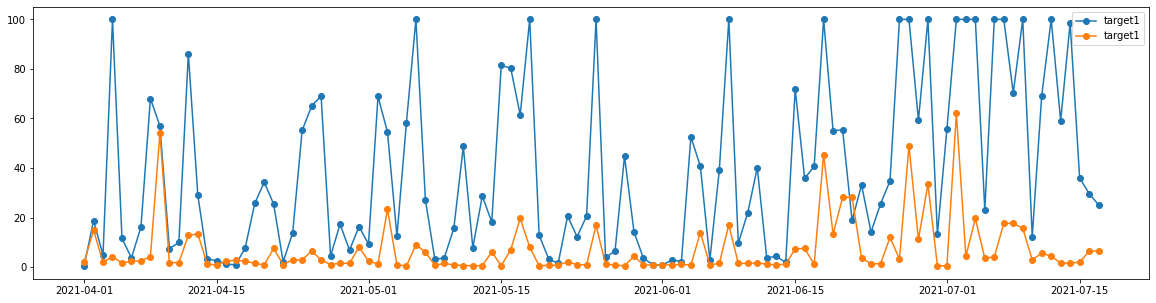

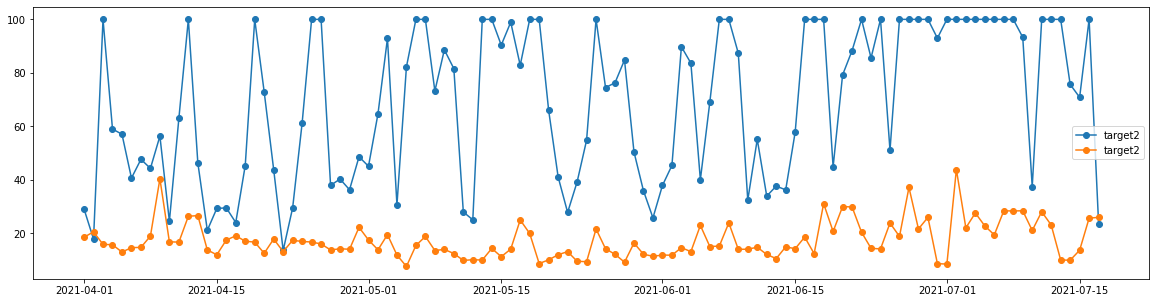

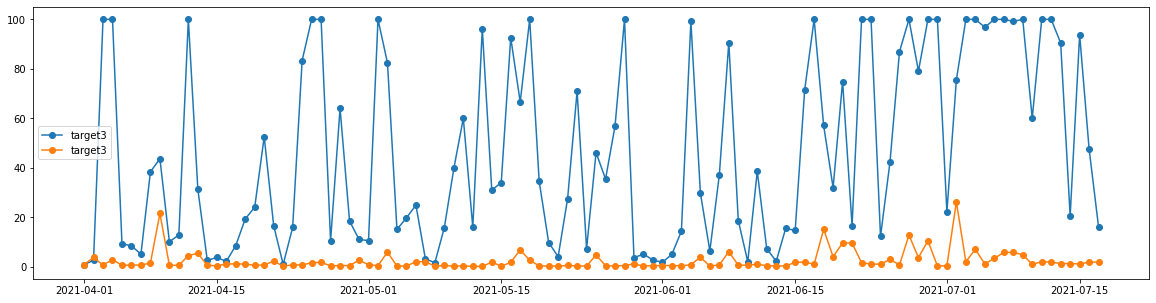

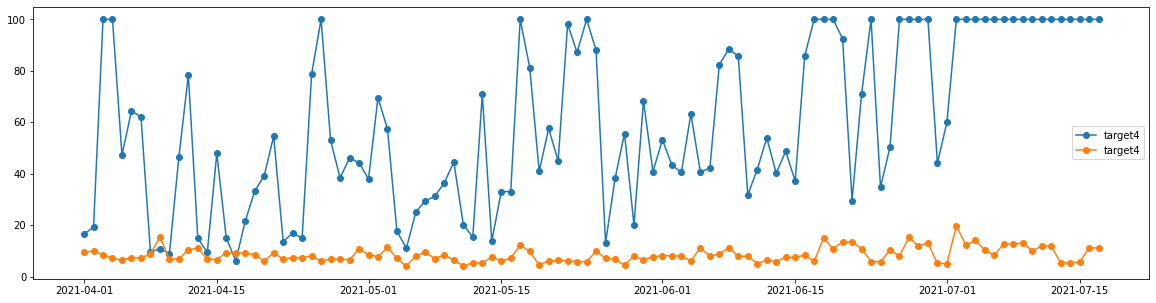

In [139]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

In [112]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [113]:
fi_data = valid_data

In [114]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [115]:
all_features_list = list(features.columns)

In [116]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

CPU times: user 2min 9s, sys: 5.34 s, total: 2min 14s
Wall time: 33.7 s


In [117]:
fi_reg

,feature,score,importance
0,playerId,5.781710,32.538805
1,numberOfFollowers,5.576958,12.063541
2,playerDebutAge,5.518665,6.234305
3,teamId,5.513947,5.762491
4,rbi__date__maxNorm__ptvf,5.507012,5.069032
5,status,5.500742,4.441964
6,homeRuns__ptvf__mean__7d,5.498611,4.228850
7,homeRuns__date__maxNorm__ptvf,5.484219,2.789714
8,homeRuns__ptvf,5.484115,2.779281
9,outsPitching__ptvf,5.482787,2.646436


In [128]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

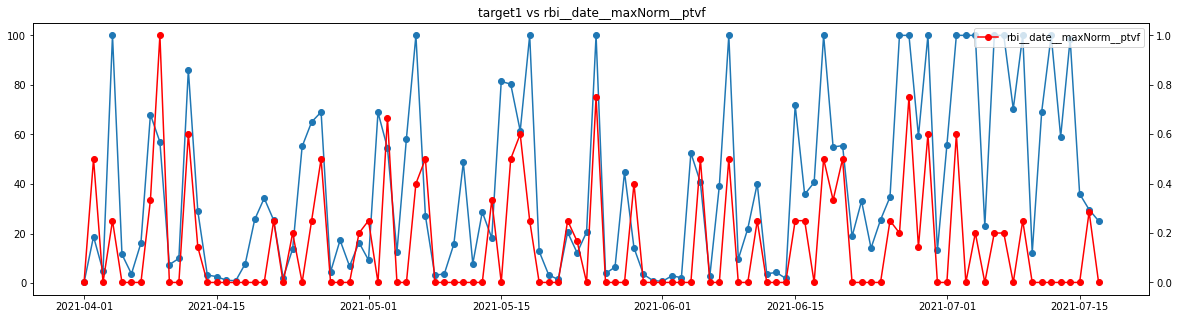

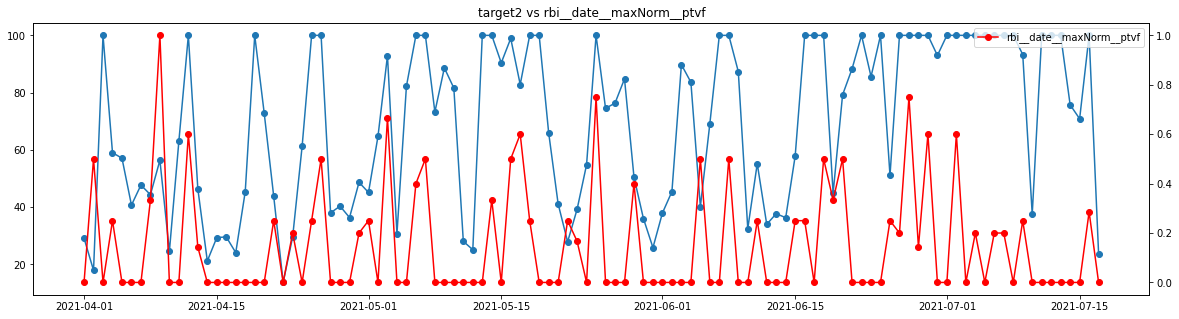

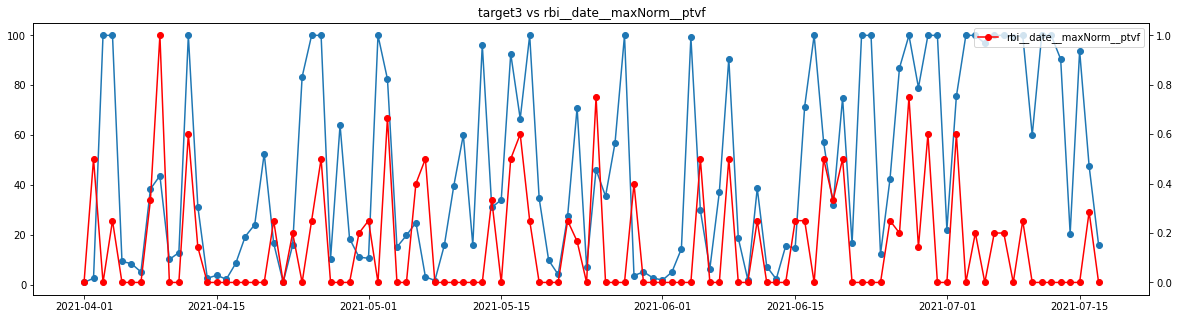

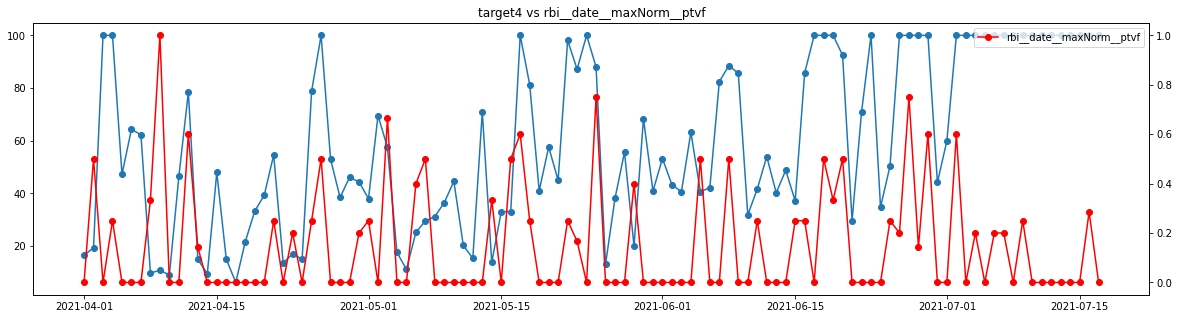

In [131]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'rbi__date__maxNorm__ptvf', playerId=660271, index=index)